## Manage Imports

In [1]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import glob
import cv2
import h5py
import os
import json
import datetime
import time
import gc
import _pickle

## Choose the Mobilenet Model

In [2]:
%mkdir mobilenet

In [3]:
%ls

DeepFeatureExtractionAndTraining.ipynb
densenet201/
DensenetDeepFeatureExtractionAndTraining.ipynb
inception/
InceptionDeepFeatureExtractionAndTraining.ipynb
inceptionresnetv2/
InceptionResnetV2DeepFeatureExtractionAndTraining.ipynb
mobilenet/
MobilenetDeepFeatureExtractionAndTraining.ipynb
MobilenetV2DeepFeatureExtractionAndTraining.ipynb
Resnet50DeepFeatureExtractionAndTraining.ipynb
VggDeepFeatureExtractionAndTraining.ipynb
xception/


In [4]:
# Configuration
model_name		= 'mobilenet'    # modify this depending on your model

weights 		= 'imagenet'
data_path 		= '../dataset/plates'
features_path	= './' + model_name + '/features.h5'
labels_path 	= './' + model_name + '/labels.h5'

## Load the Model 

In [6]:
start = time.time()

base_model = MobileNet(weights=weights)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('global_average_pooling2d_1').output)
image_size = (224, 224)

load_model_time = time.time() - start
print("[INFO] loading model time: {}".format(load_model_time))
print("[INFO] successfully loaded base model: {}".format(model_name))

model.summary()

[INFO] loading model time: 1.8110427856445312
[INFO] successfully loaded base model: mobilenet
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
________________________________

## Encode the labels from dataset directory

In [7]:
train_labels = os.listdir(data_path)
print(train_labels)
le = LabelEncoder()
le.fit([tl for tl in train_labels])

['1981', '2003', '2014']


LabelEncoder()

## Feature Extraction

In [8]:
start = time.time()

features = []
labels   = []

i = 0
for label in train_labels:
	cur_path = data_path + "/" + label
	for image_path in glob.glob(cur_path + "/*.jpg"):   
		img = image.load_img(image_path, target_size=image_size)
		x = image.img_to_array(img)
		x = np.expand_dims(x, axis=0)
		x = preprocess_input(x)
		feature = model.predict(x)
		flat = feature.flatten()
		features.append(flat)
		labels.append(label)
		if i % 100 == 0:  # print every 100th processed image
			print("[INFO] processed - {}".format(i))
		i += 1
	print("[INFO] completed label - {}".format(label))


feature_extraction_time = time.time() - start
print("[INFO] Feature extraction time: {}".format(feature_extraction_time))

[INFO] processed - 0
[INFO] processed - 100
[INFO] completed label - 1981
[INFO] processed - 200
[INFO] processed - 300
[INFO] processed - 400
[INFO] completed label - 2003
[INFO] processed - 500
[INFO] processed - 600
[INFO] processed - 700
[INFO] processed - 800
[INFO] processed - 900
[INFO] completed label - 2014
[INFO] Feature extraction time: 20.565316677093506


In [9]:
targetNames = np.unique(labels)
le = LabelEncoder()
le_labels = le.fit_transform(labels)

print ("[STATUS] training labels: {}".format(le_labels))
print ("[STATUS] training labels shape: {}".format(le_labels.shape))

h5f_data = h5py.File(features_path, 'w')
array_of_features = np.array(features)
h5f_data.create_dataset('dataset', data=array_of_features)

print("[INFO] Feature max value: {}".format(np.amax(array_of_features)))
print("[INFO] Feature min value: {}".format(np.amin(array_of_features)))

h5f_label = h5py.File(labels_path, 'w')
h5f_label.create_dataset('dataset', data=np.array(le_labels))

h5f_data.close()
h5f_label.close()

print ("[STATUS] features and labels saved..")

[STATUS] training labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

In [10]:
print ("[STATUS] end time - {}".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M")))
print(" Loading model time: {}".format(load_model_time))
print(" Feature extraction time: {}".format(feature_extraction_time))
print(" Feature extraction time per sample: {}".format(feature_extraction_time/len(le_labels)))
gc.collect()  # garbage collection

[STATUS] end time - 2019-11-22 20:40
 Loading model time: 1.8110427856445312
 Feature extraction time: 20.565316677093506
 Feature extraction time per sample: 0.020565316677093506


279

## Training imports and config

In [11]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
test_size		= 0.20
results			= './' + model_name + '/results.txt'
classifier_path = './' + model_name + '/classifier.cpickle' 
seed 		    = 4444
num_classes	    = 3

In [13]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


## Load Saved Features

In [14]:
h5f_data = h5py.File(features_path, 'r')
h5f_label = h5py.File(labels_path, 'r')

features_string = h5f_data['dataset']
labels_string   = h5f_label['dataset']

features = np.array(features_string)
labels   = np.array(labels_string)

h5f_data.close()
h5f_label.close()

print ("[INFO] Successfully loaded {} features.".format(model_name))
print ("[INFO] features shape: {}".format(features.shape))
print ("[INFO] labels shape: {}".format(labels.shape))


[INFO] Successfully loaded mobilenet features.
[INFO] features shape: (1000, 1024)
[INFO] labels shape: (1000,)


## Train / Test Split

In [15]:
print ("[INFO] split into training and testing data...")
(trainData, testData, trainLabels, testLabels) = train_test_split(np.array(features),
                                                                  np.array(labels),
                                                                  test_size=test_size,
                                                                  random_state=seed)

print ("[INFO] splitted train and test data...")
print ("[INFO] train data  : {}".format(trainData.shape))
print ("[INFO] test data   : {}".format(testData.shape))
print ("[INFO] train labels: {}".format(trainLabels.shape))
print ("[INFO] test labels : {}".format(testLabels.shape))

[INFO] split into training and testing data...
[INFO] splitted train and test data...
[INFO] train data  : (800, 1024)
[INFO] test data   : (200, 1024)
[INFO] train labels: (800,)
[INFO] test labels : (200,)


## Load Classifier or Create a New One

In [16]:
try:
    # load classifier from file, ie. logistic regression
    print("[INFO] loading classifier...")
    with open(classifier_path, 'rb') as fid:
        classifier_model = _pickle.load(fid)
except:
    print("[INFO] creating model/training...")
    classifier_model = LogisticRegression(solver='lbfgs', random_state=seed,  multi_class='auto', max_iter=5000)
    classifier_model.fit(trainData, trainLabels)

    # Save the model
    print("[INFO] saving classifier...")
    f = open(classifier_path, "wb")
    f.write(_pickle.dumps(classifier_model))
    f.close()

[INFO] loading classifier...
[INFO] creating model/training...
[INFO] saving classifier...


In [17]:
f = open(results, "w")
rank_1 = 0

# loop over test data
start = time.time()
for (label, features) in zip(testLabels, testData):
	predictions = classifier_model.predict_proba(np.atleast_2d(features))[0]
	predictions = np.argsort(predictions)[::-1][:5]
	# rank-1 prediction increment
	if label == predictions[0]:
		rank_1 += 1

# convert accuracies to percentages
rank_1 = (rank_1 / float(len(testLabels))) * 100

# write the accuracies to file
f.write("rank-1: {}\n".format(rank_1))
print("[INFO] rank 1 accuracy: {}".format(rank_1))

# evaluate the model of test data
preds = classifier_model.predict(testData)

# write the classification report to file
print(classification_report(testLabels, preds))
f.write("{}\n".format(classification_report(testLabels, preds)))
f.close()

[INFO] rank 1 accuracy: 95.0
              precision    recall  f1-score   support

           0       0.79      0.88      0.83        25
           1       0.93      0.92      0.92        60
           2       1.00      0.98      0.99       115

    accuracy                           0.95       200
   macro avg       0.91      0.93      0.92       200
weighted avg       0.95      0.95      0.95       200



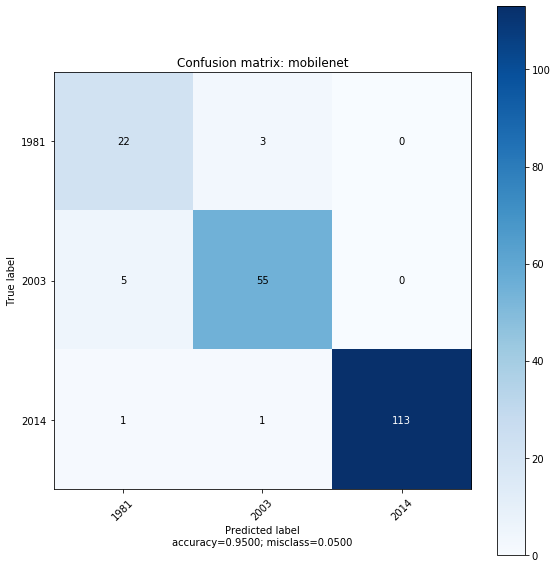

In [18]:
labels = sorted(list(os.listdir(data_path)))
title = 'Confusion matrix: ' + model_name
target_names = sorted(list(os.listdir(data_path)))
cm =confusion_matrix(testLabels, preds)
plot_confusion_matrix(cm, target_names, title=title, cmap=None, normalize=False)

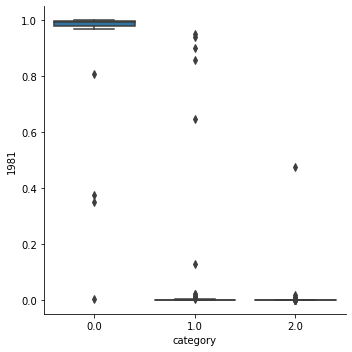

In [19]:
probs  = classifier_model.predict_proba(testData)
output = np.append(testLabels[:,None],probs, axis=1)
df     = pd.DataFrame(output, columns = ['category'] + labels)
sns.catplot(x="category", y="1981", data=df, kind="box");   # kind="violin"

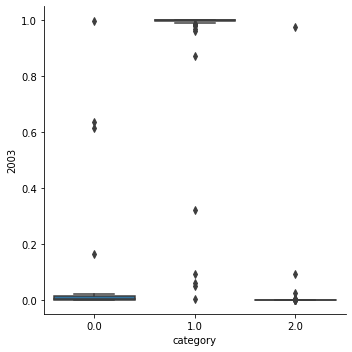

In [20]:
sns.catplot(x="category", y="2003", data=df, kind="box");   # kind="violin"

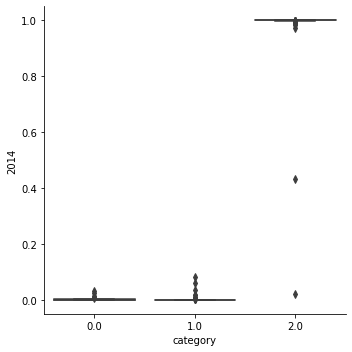

In [21]:
sns.catplot(x="category", y="2014", data=df, kind="box");   # kind="violin"